# SPATIAL RESULTS VISUALIZATION
This notebook aims to represent the outputs of the different networks and compare it whit the expected results in order analize and verify results.

In [1]:
import sys
import os

global_data_path = 'C:/Users/jaulab/Desktop/AAD/Data'
global_path = 'C:/Users/jaulab/Desktop/deepAAD_project'
# global_data_path = 'C:/Users/garce/Desktop/proyecto_2024/Data'
# global_path = 'C:/Users/jaulab/Desktop/proyecto_2024/deepAAD_project'
# global_data_path = 'D:/AAD_EEG/Data'

# Include parent dir
SCRIPT_DIR = os.path.dirname(os.path.abspath('play.ipynb'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

In [2]:
import numpy as np
import torch
# Definición funciones para trabajar simpre en float32 con numpy y pytorch
def to_numpy(tensor):
    return tensor.detach().cpu().numpy().astype(np.float32)
def to_tensor(array):
    return torch.tensor(array, dtype=torch.float32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### HRTF visualization

In [9]:
import numpy as np
from utils.datasets import CustomDataset
from utils.functional import get_data_path
import scipy
import os
import torch
global_path = 'C:/users/jaulab/Desktop'
import matplotlib.pyplot as plt

In [11]:
# Load from the Custom dataset
dataset ='fulsang'
data_path = get_data_path(global_data_path, dataset)
train_set = CustomDataset('fulsang', data_path, 'test', 'S1', window=128, hop=1, hrtf=True, cv_fold=None)

In [12]:
att_wav = train_set.stima.T
unatt_wav = train_set.stimb.T
att_wav.shape

torch.Size([19200, 2])

In [13]:
# First trial
# trial_range = range(0,32000) # trial 1
trial_range = range(0, 6400) # trial 2
# trial_range = range(3072, 4800) # trial switch

env_L_att = att_wav[trial_range,0]
env_R_att = att_wav[trial_range,1]
env_L_unatt = unatt_wav[trial_range,0]
env_R_unatt = unatt_wav[trial_range,1]
env_L_att.shape, env_R_att.shape

(torch.Size([6400]), torch.Size([6400]))

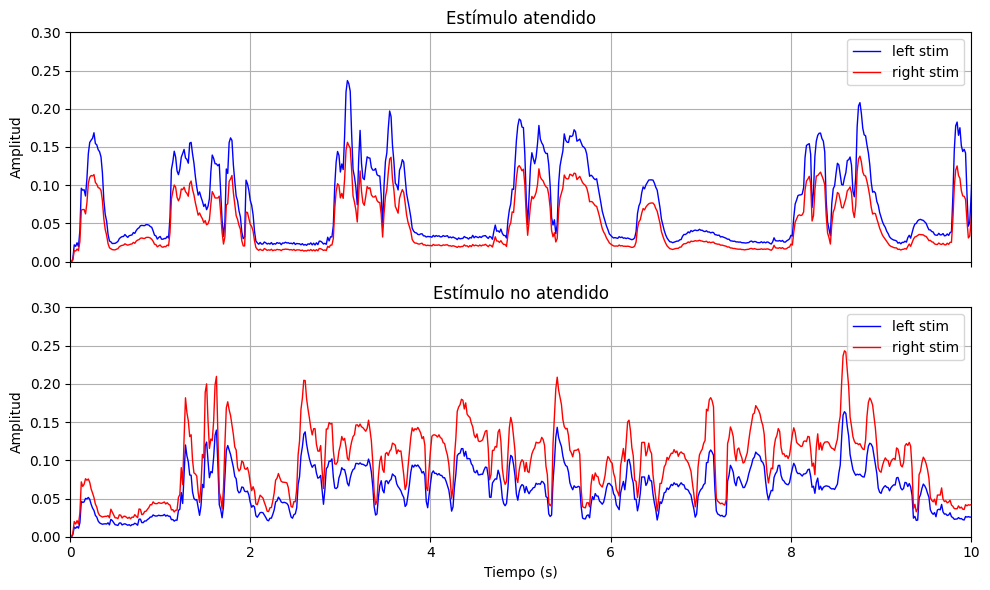

In [14]:
# Representar envolvente derecha
x = np.arange(0, len(env_L_att)) / 64
# Crear figura con tres subgráficas
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Primera gráfica
axs[0].plot(x, env_L_att, color='blue', linewidth=1, label='left stim')
axs[0].plot(x, env_R_att, color='red', linewidth=1, label='right stim')
axs[0].set_title('Estímulo atendido')
axs[0].set_ylabel('Amplitud')
axs[0].set_xlim([0, 10])
axs[0].set_ylim([0, 0.3])
axs[0].grid()
axs[0].legend()

# Segunda gráfica
axs[1].plot(x, env_L_unatt, color='blue', linewidth=1, label='left stim')
axs[1].plot(x, env_R_unatt, color='red', linewidth=1, label='right stim')
axs[1].set_title('Estímulo no atendido')
axs[1].set_xlabel('Tiempo (s)')
axs[1].set_ylabel('Amplitud')
axs[1].set_xlim([0, 10])
axs[1].set_ylim([0, 0.3])
axs[1].grid()
axs[1].legend()

# # Tercera gráfica
# axs[2].plot(x, env_L, color='blue', linewidth=1, label='left stim')
# axs[2].plot(x, env_R, color='red', linewidth=1, label='right stim')
# axs[2].set_title('Estímulo Atendido 3')
# axs[2].set_xlabel('Tiempo (s)')
# axs[2].set_ylabel('Amplitud')
# axs[2].set_xlim([0, 10])
# axs[2].set_ylim([0, 0.3])
# axs[2].grid()
# axs[2].legend()

# Ajustar espacios entre las gráficas
plt.tight_layout()
plt.show()

### Predicciones modelo

In [12]:
import yaml
from models.dnn import CNN
from utils.functional import get_mdl_name
from torch.utils.data import DataLoader

In [13]:
# Load yaml config file
config_path = '../configs/spatial_audio/ild_best_models.yaml'
with open(config_path, 'r') as archivo:
    config = yaml.safe_load(archivo)

In [14]:
config['runs'][0]

{'model': 'CNN',
 'train_params': {'batch_size': 128,
  'max_epoch': 200,
  'lr': '2e-05',
  'weight_decay': '1e-08',
  'early_stopping_patience': 2,
  'scheduler_patience': 1,
  'shuffle': False,
  'batch_rnd_sampler': True},
 'dataset_params': {'window': 50,
  'hop': 1,
  'fixed': False,
  'rnd_trials': False,
  'window_pred': False,
  'hrtf': True},
 'loss_params': {'mode': 'corr_ild_mse', 'alpha_end': 0.02},
 'model_params': {'F1': 8,
  'D': 16,
  'AP1': 2,
  'AP2': 4,
  'dropout': 0.3,
  'input_samples': 50,
  'output_dim': 2}}

In [15]:
# Extract the model path
config_run = config['runs'][0]
mdl_name = get_mdl_name(config_run)
mdl_path = os.path.join('results', 'spatial_audio', 'population', 'models', 'fulsang_data', mdl_name)
mdl_path

'results\\spatial_audio\\population\\models\\fulsang_data\\CNN_batch=128_block=50_lr=2e-05_dr=0.3_corr_ild_mse_alpha=0.02_hrtf'

In [16]:
# Get the model filename to complete the path
mdl_filename = os.listdir('../'+mdl_path)[0]
mdl_full_path = os.path.join(mdl_path, mdl_filename)
mdl_full_path

'results\\spatial_audio\\population\\models\\fulsang_data\\CNN_batch=128_block=50_lr=2e-05_dr=0.3_corr_ild_mse_alpha=0.02_hrtf\\CNN_epoch=13_acc=-0.0819.ckpt'

In [17]:
# Load the model state dict
config_run['model_params']['input_channels'] = 64
mdl = CNN(**config_run['model_params'])
mdl.load_state_dict(torch.load('../'+mdl_full_path, map_location=torch.device(device)))
mdl.eval()

CNN(
  (temporal): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (spatial): Sequential(
    (0): Conv2d(8, 128, kernel_size=(1, 64), stride=(1, 1), groups=8)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (depthwise): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
    (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0)
    (5): Dropout2d(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linea

In [18]:
# Load the data
dataset ='fulsang'
data_path = get_data_path(global_data_path, dataset)
data_len = 32000 # 50s
dataset = CustomDataset('fulsang', data_path, 'test', 'S1', window=50, hop=1, hrtf=True)
dataset.eeg.shape

torch.Size([64, 19200])

In [19]:
# Get window len and init (dataloader functionality)
init = 3200
len = 1280 # 20s
input_data= torch.stack([dataset.eeg[:, init+n:init+n+50] for n in range(1280)])
input_data.shape

torch.Size([1280, 64, 50])

In [20]:
# Get model predictions
preds = mdl(input_data).detach()
preds.shape

torch.Size([1280, 2])

In [21]:
# Get HRTFs
att_wav = train_set.stima.T
unatt_wav = train_set.stimb.T

trial_range = np.arange(init, init+len)
att_wav = att_wav[trial_range, :]
unatt_wav = unatt_wav[trial_range, :]

env_L_att = att_wav[:,0]
env_R_att = att_wav[:,1]
env_L_unatt = unatt_wav[:,0]
env_R_unatt = unatt_wav[:,1]
env_L_att.shape, env_R_att.shape

(torch.Size([1280]), torch.Size([1280]))

In [22]:
env_L_att.shape[0], preds.shape, preds[:, 0]

(1280,
 torch.Size([1280, 2]),
 tensor([0.1522, 0.1531, 0.1488,  ..., 0.3921, 0.4143, 0.4105]))

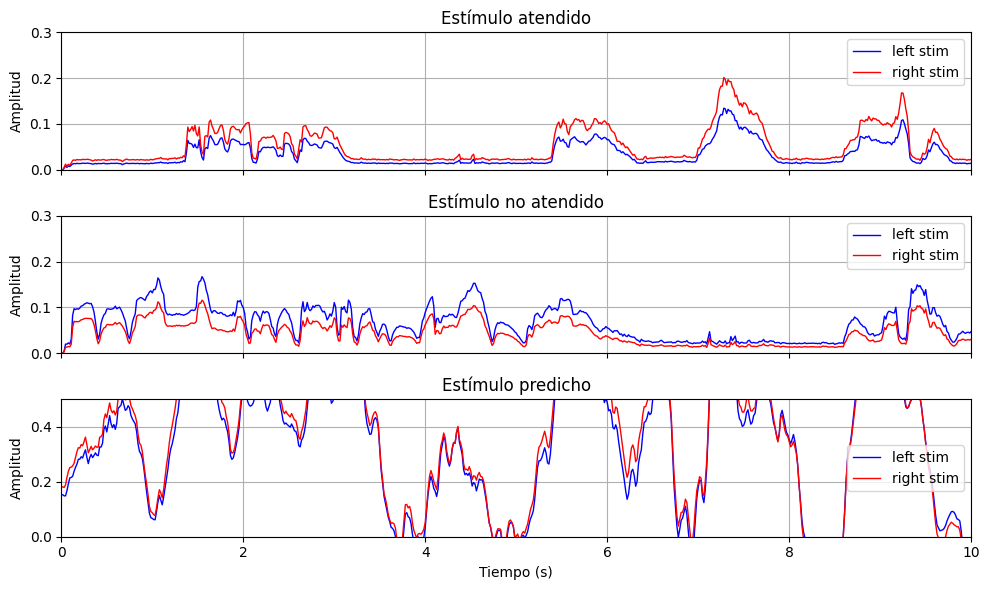

In [23]:
# Representar envolvente derecha
x = np.arange(0, env_L_att.shape[0]) / 64
# Crear figura con tres subgráficas
fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Primera gráfica
axs[0].plot(x, env_L_att, color='blue', linewidth=1, label='left stim')
axs[0].plot(x, env_R_att, color='red', linewidth=1, label='right stim')
axs[0].set_title('Estímulo atendido')
axs[0].set_ylabel('Amplitud')
axs[0].set_xlim([0, 10])
axs[0].set_ylim([0, 0.3])
axs[0].grid()
axs[0].legend()

# Segunda gráfica
axs[1].plot(x, env_L_unatt, color='blue', linewidth=1, label='left stim')
axs[1].plot(x, env_R_unatt, color='red', linewidth=1, label='right stim')
axs[1].set_title('Estímulo no atendido')
axs[1].set_ylabel('Amplitud')
axs[1].set_xlim([0, 10])
axs[1].set_ylim([0, 0.3])
axs[1].grid()
axs[1].legend()

# Tercera gráfica
axs[2].plot(x, preds[:, 0], color='blue', linewidth=1, label='left stim')
axs[2].plot(x, preds[:, 1], color='red', linewidth=1, label='right stim')
axs[2].set_title('Estímulo predicho')
axs[2].set_xlabel('Tiempo (s)')
axs[2].set_ylabel('Amplitud')
axs[2].set_xlim([0, 10])
axs[2].set_ylim([0, 0.5])
axs[2].grid()
axs[2].legend()

# Ajustar espacios entre las gráficas
plt.tight_layout()
plt.show()

### Computing metrics

In [24]:
from utils.loss_functions import CustomLoss
criterion = CustomLoss(mode='corr_ild_mse', alpha_end=0.02)

In [25]:
def compute_correlation(preds, targets, eps=1e-8):
        
    # Compute means
    preds_mean = preds.mean(dim=1, keepdim=True)
    targets_mean = targets.mean(dim=1, keepdim=True)
    
    # Compute deviations
    preds_dev = preds - preds_mean
    targets_dev = targets - targets_mean
    
    # Compute correlation for all channels simultaneously
    numerator = (preds_dev * targets_dev).sum(dim=1)
    denominator = torch.sqrt((preds_dev**2).sum(dim=1) * (targets_dev**2).sum(dim=1)) + eps
    return numerator / denominator

def compute_ild(left_channel, right_channel, eps=1e-8):

    # Calculate RMS for both channels
    rms_left = torch.sqrt((left_channel**2).mean()) + eps
    rms_right = torch.sqrt((right_channel**2).mean()) + eps
    
    # Calculate ILD in dB
    return 10 * torch.log10(rms_left / rms_right)

In [26]:
preds.shape, att_wav.shape

(torch.Size([1280, 2]), torch.Size([1280, 2]))

In [27]:
corr_att = compute_correlation(preds=preds.T, targets=att_wav.T)
corr_unatt = compute_correlation(preds=preds.T, targets=unatt_wav.T)
corr_att, corr_unatt

(tensor([0.4095, 0.3979]), tensor([0.0680, 0.1018]))

In [28]:
ild_pred = compute_ild(preds[:,0], preds[:,1], eps=1e-8)
ild_att = compute_ild(att_wav[:,0], att_wav[:,1], eps=1e-8)
ild_unatt = compute_ild(unatt_wav[:,0], unatt_wav[:,1], eps=1e-8)
ild_pred, ild_att, ild_unatt

(tensor(-0.4128), tensor(-1.8358), tensor(1.7488))

### Normalization

In [54]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def normalize()

### STA Net

In [3]:
from models.sta_net import EEGAttentionModel
mdl = EEGAttentionModel()
mdl

EEGAttentionModel(
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (space_attention): MySpaceAttention(
    (my_se_dense): Sequential(
      (0): Conv2d(64, 10, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1), padding=same)
      (3): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.5, inplace=False)
      (5): Linear(in_features=10, out_features=8, bias=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=8, out_features=64, bias=True)
    )
  )
  (conv1d): Conv1d(64, 5, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1d): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (temporal_attention): MyTemporalAttention(
    (dense_k): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=64, out_features

In [5]:
# forward pass
x = torch.randn((64, 128, 64))
x = mdl(x)
x, x.shape

Conv2d: input shape torch.Size([64, 64, 1, 128]) -> output shape torch.Size([64, 10, 1, 128])
ReLU: input shape torch.Size([64, 10, 1, 128]) -> output shape torch.Size([64, 10, 1, 128])
Conv2d: input shape torch.Size([64, 10, 1, 128]) -> output shape torch.Size([64, 10, 1, 128])
MaxPool2d: input shape torch.Size([64, 10, 1, 128]) -> output shape torch.Size([64, 10, 1, 10])
Dropout: input shape torch.Size([64, 10, 1, 10]) -> output shape torch.Size([64, 10, 1, 10])
Linear: input shape torch.Size([64, 10, 1, 10]) -> output shape torch.Size([64, 10, 1, 8])
ReLU: input shape torch.Size([64, 10, 1, 8]) -> output shape torch.Size([64, 10, 1, 8])
Dropout: input shape torch.Size([64, 10, 1, 8]) -> output shape torch.Size([64, 10, 1, 8])
Linear: input shape torch.Size([64, 10, 1, 8]) -> output shape torch.Size([64, 10, 1, 64])



KeyboardInterrupt

